_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [2]:
test.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,114835,7 - ELEVEN,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,"{'longitude': '-87.62935653990546', 'latitude'...",0
1,1575555,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'...",0
2,671061,TROTTER'S TO GO,TROTTER'S TO GO,1092634.0,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,CHICAGO,IL,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,"{'longitude': '-87.66204067083224', 'latitude'...",0
3,1965844,BIG G'S PIZZA,BIG G'S PIZZA,2334691.0,Restaurant,Risk 1 (High),1132 W TAYLOR ST,CHICAGO,IL,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,"{'longitude': '-87.65550098867566', 'latitude'...",1
4,1751669,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,3491970.0,School,Risk 2 (Medium),1021 E 83RD,CHICAGO,IL,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,"{'longitude': '-87.59929083361996', 'latitude'...",1


In [3]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [98]:
def wrangle(X):
    X = X.copy()
    X['Inspection Date'] = X['Inspection Date'].astype('datetime')
    return X
train_wrangled = wrangle(train)

TypeError: data type 'datetime' not understood

In [4]:
from sklearn.model_selection import train_test_split

y = train['Fail']
y_test = test['Fail']

X = train.drop(columns='Fail')
X_test = test.drop(columns='Fail')

#I'm going to keep these ID so that I can make a shapely graph later
X_id = train['Inspection ID']
test_id = test['Inspection ID']

X_train, X_val, y_train, y_val, X_id_train, X_id_test = train_test_split(
    X, y, X_id,  test_size=0.2, random_state=7)

X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_id_train.shape, X_id_test.shape

((41532, 16), (10384, 16), (41532,), (10384,), (41532,), (10384,))

In [5]:
X_train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
dtype: object

In [6]:
y_train.value_counts(normalize=True)

0    0.74073
1    0.25927
Name: Fail, dtype: float64

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

dummy = DummyClassifier(strategy= 'stratified',random_state=7)
y_dummy_pred = dummy.fit(X_train, y_train).predict(y_test)
baseline_auc = roc_auc_score(y_test, y_dummy_pred)
baseline_auc

0.49935677777589105

In [37]:
#I will try to spot the leak by using a cross validation

import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

leak = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'), 
    #DecisionTreeClassifier(max_depth=15)
    RandomForestClassifier(n_estimators=100, random_state=7, n_jobs=-1)
)

scores = cross_val_score(leak, X.drop(columns='Inspection Date'), y, cv=10, scoring='roc_auc', n_jobs=-1)
print('Validation ROC AUC:', scores)

Validation ROC AUC: [0.64263019 0.62809586 0.62630874 0.62466816 0.62554972 0.62362399
 0.64126969 0.64049152 0.63484061 0.61937236]


### At this moment I was not able to spot the leakage by looking at AUCROC scores.

In [38]:
import graphviz
from sklearn.tree import export_graphviz

leak.fit(X_train, y_train)
tree = leak.named_steps['decisiontreeclassifier']
encoder = leak.named_steps['targetencoder']
feature_names = encoder.transform(X_train).columns
feature_names[tree.feature_importances_ > 0]

dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=feature_names, class_names=['False', 'True'], 
                           filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

KeyError: 'decisiontreeclassifier'

In [42]:
leak.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['DBA Name', 'AKA Name', 'Facility Type',
                                      'Risk', 'Address', 'City', 'State',
                                      'Inspection Date', 'Inspection Type',
                                      'Violations', 'Location'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'DBA Name',
                                          'data_type': dtype('O'),
                                          'mapping': SZYMANSKI BROS, INC                     1
YUMMY YUMMY NOO...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                    

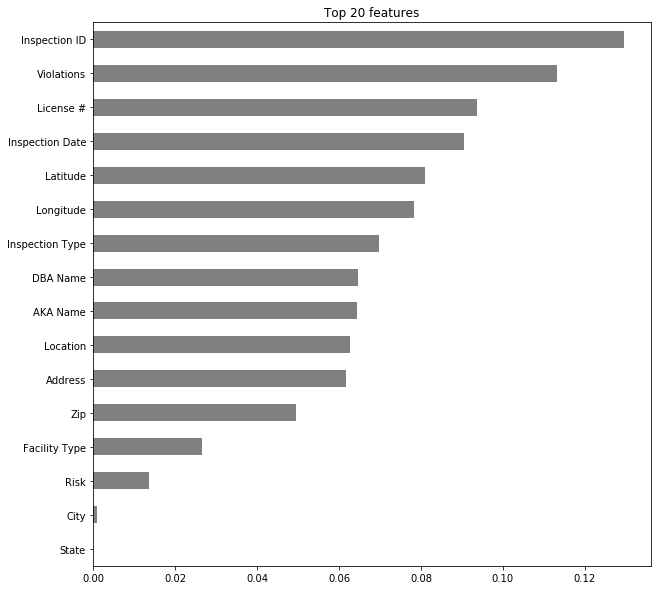

In [44]:
# Get feature importances
rf = leak.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [142]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

X_transformed = transformers.transform(X)

encoder = ce.OrdinalEncoder()
# X_test_encoded = encoder.fit_transform(X_test)

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

In [143]:
from xgboost import XGBClassifier

#model = XGBClassifier()



eval_set = [(X_train_imputed, y_train), 
            (X_val_imputed, y_val),
            (X_test_imputed, y_test)]

model = XGBClassifier(
    n_estimators=10000, # <= 1000 trees, depends on early stopping
    max_depth=2,       # try deeper trees because of high cardinality categoricals
    learning_rate=.01, # try higher learning rate
    n_jobs=-1
)

model.fit(X_train_imputed, y_train, eval_set=eval_set, 
          eval_metric='auc', early_stopping_rounds=300)

[0]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 300 rounds.
[1]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
[2]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
[3]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
[4]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
[5]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
[6]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
[7]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
[8]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
[9]	validation_0-auc:0.631352	validation_1-auc:0.584383	validation_2-auc:0.581773
[10]	validation_0-auc:

[97]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[98]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[99]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[100]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[101]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[102]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[103]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[104]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[105]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[106]	validation_0-auc:0.666883	validation_1-auc:0.603128	validation_2-auc:0.595782
[107]	validation_0-auc:0.666896	validation_1-auc:0.603506	validation_2-auc:0.596071
[108]	validation_0-auc:0.666896	validation_1-auc:0.603506	validation_2-auc:0.59

[195]	validation_0-auc:0.677961	validation_1-auc:0.626751	validation_2-auc:0.620239
[196]	validation_0-auc:0.677961	validation_1-auc:0.626751	validation_2-auc:0.620239
[197]	validation_0-auc:0.677961	validation_1-auc:0.626751	validation_2-auc:0.620239
[198]	validation_0-auc:0.678106	validation_1-auc:0.629487	validation_2-auc:0.624568
[199]	validation_0-auc:0.678111	validation_1-auc:0.629487	validation_2-auc:0.624568
[200]	validation_0-auc:0.678111	validation_1-auc:0.629487	validation_2-auc:0.624568
[201]	validation_0-auc:0.678111	validation_1-auc:0.629487	validation_2-auc:0.624568
[202]	validation_0-auc:0.678108	validation_1-auc:0.629487	validation_2-auc:0.624568
[203]	validation_0-auc:0.678109	validation_1-auc:0.629487	validation_2-auc:0.624568
[204]	validation_0-auc:0.678109	validation_1-auc:0.629487	validation_2-auc:0.624568
[205]	validation_0-auc:0.678109	validation_1-auc:0.629487	validation_2-auc:0.624568
[206]	validation_0-auc:0.678109	validation_1-auc:0.629487	validation_2-auc:0

[294]	validation_0-auc:0.70054	validation_1-auc:0.632039	validation_2-auc:0.627652
[295]	validation_0-auc:0.700156	validation_1-auc:0.631802	validation_2-auc:0.627577
[296]	validation_0-auc:0.700245	validation_1-auc:0.631806	validation_2-auc:0.627627
[297]	validation_0-auc:0.701012	validation_1-auc:0.631804	validation_2-auc:0.627598
[298]	validation_0-auc:0.700645	validation_1-auc:0.631742	validation_2-auc:0.62762
[299]	validation_0-auc:0.700634	validation_1-auc:0.631721	validation_2-auc:0.627628
[300]	validation_0-auc:0.700717	validation_1-auc:0.631769	validation_2-auc:0.627611
[301]	validation_0-auc:0.700801	validation_1-auc:0.631815	validation_2-auc:0.627724
[302]	validation_0-auc:0.700823	validation_1-auc:0.631817	validation_2-auc:0.627737
[303]	validation_0-auc:0.700882	validation_1-auc:0.631739	validation_2-auc:0.627702
[304]	validation_0-auc:0.700876	validation_1-auc:0.631788	validation_2-auc:0.627725
[305]	validation_0-auc:0.700973	validation_1-auc:0.631803	validation_2-auc:0.6

[392]	validation_0-auc:0.705283	validation_1-auc:0.632685	validation_2-auc:0.628932
[393]	validation_0-auc:0.70524	validation_1-auc:0.63264	validation_2-auc:0.629008
[394]	validation_0-auc:0.705331	validation_1-auc:0.632669	validation_2-auc:0.628985
[395]	validation_0-auc:0.705328	validation_1-auc:0.633879	validation_2-auc:0.630461
[396]	validation_0-auc:0.705451	validation_1-auc:0.634711	validation_2-auc:0.631116
[397]	validation_0-auc:0.705351	validation_1-auc:0.63478	validation_2-auc:0.631311
[398]	validation_0-auc:0.705307	validation_1-auc:0.634808	validation_2-auc:0.631307
[399]	validation_0-auc:0.705496	validation_1-auc:0.634807	validation_2-auc:0.631287
[400]	validation_0-auc:0.705466	validation_1-auc:0.634777	validation_2-auc:0.631224
[401]	validation_0-auc:0.705448	validation_1-auc:0.634679	validation_2-auc:0.631113
[402]	validation_0-auc:0.705431	validation_1-auc:0.633482	validation_2-auc:0.629725
[403]	validation_0-auc:0.705431	validation_1-auc:0.633507	validation_2-auc:0.62

[490]	validation_0-auc:0.711142	validation_1-auc:0.641483	validation_2-auc:0.636551
[491]	validation_0-auc:0.71121	validation_1-auc:0.642088	validation_2-auc:0.637082
[492]	validation_0-auc:0.711367	validation_1-auc:0.641338	validation_2-auc:0.636385
[493]	validation_0-auc:0.711417	validation_1-auc:0.641347	validation_2-auc:0.636392
[494]	validation_0-auc:0.711483	validation_1-auc:0.641775	validation_2-auc:0.636873
[495]	validation_0-auc:0.711489	validation_1-auc:0.642144	validation_2-auc:0.637192
[496]	validation_0-auc:0.71149	validation_1-auc:0.642249	validation_2-auc:0.637311
[497]	validation_0-auc:0.711428	validation_1-auc:0.641714	validation_2-auc:0.636766
[498]	validation_0-auc:0.711482	validation_1-auc:0.642125	validation_2-auc:0.637194
[499]	validation_0-auc:0.711477	validation_1-auc:0.642372	validation_2-auc:0.637518
[500]	validation_0-auc:0.711519	validation_1-auc:0.642362	validation_2-auc:0.637539
[501]	validation_0-auc:0.711508	validation_1-auc:0.642264	validation_2-auc:0.6

[588]	validation_0-auc:0.714182	validation_1-auc:0.644457	validation_2-auc:0.640008
[589]	validation_0-auc:0.714213	validation_1-auc:0.644484	validation_2-auc:0.640067
[590]	validation_0-auc:0.714202	validation_1-auc:0.644399	validation_2-auc:0.639952
[591]	validation_0-auc:0.714269	validation_1-auc:0.644344	validation_2-auc:0.639934
[592]	validation_0-auc:0.714219	validation_1-auc:0.644386	validation_2-auc:0.639993
[593]	validation_0-auc:0.714268	validation_1-auc:0.644408	validation_2-auc:0.639997
[594]	validation_0-auc:0.714303	validation_1-auc:0.644406	validation_2-auc:0.639998
[595]	validation_0-auc:0.714327	validation_1-auc:0.644622	validation_2-auc:0.640198
[596]	validation_0-auc:0.714324	validation_1-auc:0.644647	validation_2-auc:0.640252
[597]	validation_0-auc:0.714302	validation_1-auc:0.644553	validation_2-auc:0.640125
[598]	validation_0-auc:0.714352	validation_1-auc:0.644647	validation_2-auc:0.640199
[599]	validation_0-auc:0.714438	validation_1-auc:0.644609	validation_2-auc:0

[686]	validation_0-auc:0.717087	validation_1-auc:0.646702	validation_2-auc:0.642551
[687]	validation_0-auc:0.717107	validation_1-auc:0.646725	validation_2-auc:0.642597
[688]	validation_0-auc:0.717098	validation_1-auc:0.646749	validation_2-auc:0.642612
[689]	validation_0-auc:0.717102	validation_1-auc:0.646779	validation_2-auc:0.642612
[690]	validation_0-auc:0.717159	validation_1-auc:0.6468	validation_2-auc:0.642633
[691]	validation_0-auc:0.717209	validation_1-auc:0.646832	validation_2-auc:0.642687
[692]	validation_0-auc:0.717249	validation_1-auc:0.646844	validation_2-auc:0.642665
[693]	validation_0-auc:0.717215	validation_1-auc:0.646919	validation_2-auc:0.642769
[694]	validation_0-auc:0.717229	validation_1-auc:0.646978	validation_2-auc:0.642828
[695]	validation_0-auc:0.717272	validation_1-auc:0.646969	validation_2-auc:0.642828
[696]	validation_0-auc:0.717271	validation_1-auc:0.646969	validation_2-auc:0.642827
[697]	validation_0-auc:0.717307	validation_1-auc:0.646956	validation_2-auc:0.6

[785]	validation_0-auc:0.719856	validation_1-auc:0.648324	validation_2-auc:0.644883
[786]	validation_0-auc:0.719864	validation_1-auc:0.648317	validation_2-auc:0.644874
[787]	validation_0-auc:0.719869	validation_1-auc:0.648317	validation_2-auc:0.644875
[788]	validation_0-auc:0.719918	validation_1-auc:0.648309	validation_2-auc:0.644887
[789]	validation_0-auc:0.719962	validation_1-auc:0.648335	validation_2-auc:0.644917
[790]	validation_0-auc:0.720064	validation_1-auc:0.648387	validation_2-auc:0.644939
[791]	validation_0-auc:0.720082	validation_1-auc:0.648354	validation_2-auc:0.644944
[792]	validation_0-auc:0.7201	validation_1-auc:0.648383	validation_2-auc:0.644986
[793]	validation_0-auc:0.72011	validation_1-auc:0.648316	validation_2-auc:0.644921
[794]	validation_0-auc:0.720164	validation_1-auc:0.648326	validation_2-auc:0.644926
[795]	validation_0-auc:0.720177	validation_1-auc:0.648378	validation_2-auc:0.644958
[796]	validation_0-auc:0.720201	validation_1-auc:0.648428	validation_2-auc:0.64

[883]	validation_0-auc:0.722251	validation_1-auc:0.649396	validation_2-auc:0.646087
[884]	validation_0-auc:0.722267	validation_1-auc:0.649436	validation_2-auc:0.646117
[885]	validation_0-auc:0.722273	validation_1-auc:0.649506	validation_2-auc:0.646163
[886]	validation_0-auc:0.722303	validation_1-auc:0.649499	validation_2-auc:0.646173
[887]	validation_0-auc:0.722319	validation_1-auc:0.649506	validation_2-auc:0.646181
[888]	validation_0-auc:0.722372	validation_1-auc:0.64949	validation_2-auc:0.64619
[889]	validation_0-auc:0.722407	validation_1-auc:0.649522	validation_2-auc:0.646224
[890]	validation_0-auc:0.722414	validation_1-auc:0.649526	validation_2-auc:0.646208
[891]	validation_0-auc:0.722486	validation_1-auc:0.649596	validation_2-auc:0.646262
[892]	validation_0-auc:0.722515	validation_1-auc:0.649597	validation_2-auc:0.64626
[893]	validation_0-auc:0.722573	validation_1-auc:0.649631	validation_2-auc:0.646269
[894]	validation_0-auc:0.722605	validation_1-auc:0.649607	validation_2-auc:0.64

[981]	validation_0-auc:0.72458	validation_1-auc:0.650638	validation_2-auc:0.647245
[982]	validation_0-auc:0.724593	validation_1-auc:0.650682	validation_2-auc:0.647285
[983]	validation_0-auc:0.724597	validation_1-auc:0.650608	validation_2-auc:0.647239
[984]	validation_0-auc:0.72461	validation_1-auc:0.650619	validation_2-auc:0.647247
[985]	validation_0-auc:0.724661	validation_1-auc:0.650681	validation_2-auc:0.647291
[986]	validation_0-auc:0.724657	validation_1-auc:0.650691	validation_2-auc:0.647278
[987]	validation_0-auc:0.724687	validation_1-auc:0.650712	validation_2-auc:0.647298
[988]	validation_0-auc:0.724696	validation_1-auc:0.650702	validation_2-auc:0.647295
[989]	validation_0-auc:0.724712	validation_1-auc:0.650725	validation_2-auc:0.647316
[990]	validation_0-auc:0.72472	validation_1-auc:0.650752	validation_2-auc:0.647342
[991]	validation_0-auc:0.724735	validation_1-auc:0.650734	validation_2-auc:0.647358
[992]	validation_0-auc:0.724778	validation_1-auc:0.650756	validation_2-auc:0.64

[1078]	validation_0-auc:0.726284	validation_1-auc:0.651711	validation_2-auc:0.648189
[1079]	validation_0-auc:0.726307	validation_1-auc:0.651721	validation_2-auc:0.648197
[1080]	validation_0-auc:0.726313	validation_1-auc:0.651701	validation_2-auc:0.648211
[1081]	validation_0-auc:0.726305	validation_1-auc:0.651704	validation_2-auc:0.648202
[1082]	validation_0-auc:0.726344	validation_1-auc:0.651697	validation_2-auc:0.648185
[1083]	validation_0-auc:0.72636	validation_1-auc:0.651731	validation_2-auc:0.648207
[1084]	validation_0-auc:0.726365	validation_1-auc:0.651785	validation_2-auc:0.648251
[1085]	validation_0-auc:0.726361	validation_1-auc:0.651693	validation_2-auc:0.648186
[1086]	validation_0-auc:0.726382	validation_1-auc:0.651673	validation_2-auc:0.648174
[1087]	validation_0-auc:0.726411	validation_1-auc:0.651624	validation_2-auc:0.648124
[1088]	validation_0-auc:0.72644	validation_1-auc:0.651666	validation_2-auc:0.648167
[1089]	validation_0-auc:0.726477	validation_1-auc:0.651678	validati

[1175]	validation_0-auc:0.727905	validation_1-auc:0.652822	validation_2-auc:0.649241
[1176]	validation_0-auc:0.727912	validation_1-auc:0.652867	validation_2-auc:0.64928
[1177]	validation_0-auc:0.727921	validation_1-auc:0.65288	validation_2-auc:0.649292
[1178]	validation_0-auc:0.727951	validation_1-auc:0.652894	validation_2-auc:0.649296
[1179]	validation_0-auc:0.727968	validation_1-auc:0.652865	validation_2-auc:0.649309
[1180]	validation_0-auc:0.728003	validation_1-auc:0.652882	validation_2-auc:0.649325
[1181]	validation_0-auc:0.728048	validation_1-auc:0.652896	validation_2-auc:0.64935
[1182]	validation_0-auc:0.728077	validation_1-auc:0.652857	validation_2-auc:0.649328
[1183]	validation_0-auc:0.728114	validation_1-auc:0.652904	validation_2-auc:0.649366
[1184]	validation_0-auc:0.728117	validation_1-auc:0.652909	validation_2-auc:0.649358
[1185]	validation_0-auc:0.728132	validation_1-auc:0.652936	validation_2-auc:0.649376
[1186]	validation_0-auc:0.728139	validation_1-auc:0.652955	validatio

[1272]	validation_0-auc:0.729671	validation_1-auc:0.654022	validation_2-auc:0.650627
[1273]	validation_0-auc:0.72966	validation_1-auc:0.654047	validation_2-auc:0.65066
[1274]	validation_0-auc:0.729669	validation_1-auc:0.654071	validation_2-auc:0.650682
[1275]	validation_0-auc:0.729669	validation_1-auc:0.654113	validation_2-auc:0.650711
[1276]	validation_0-auc:0.729676	validation_1-auc:0.654113	validation_2-auc:0.650707
[1277]	validation_0-auc:0.729689	validation_1-auc:0.654125	validation_2-auc:0.65074
[1278]	validation_0-auc:0.729714	validation_1-auc:0.654139	validation_2-auc:0.650743
[1279]	validation_0-auc:0.72975	validation_1-auc:0.654145	validation_2-auc:0.65076
[1280]	validation_0-auc:0.729771	validation_1-auc:0.654125	validation_2-auc:0.650759
[1281]	validation_0-auc:0.729779	validation_1-auc:0.654119	validation_2-auc:0.650751
[1282]	validation_0-auc:0.729796	validation_1-auc:0.654172	validation_2-auc:0.650784
[1283]	validation_0-auc:0.729805	validation_1-auc:0.654173	validation_

[1369]	validation_0-auc:0.731228	validation_1-auc:0.65514	validation_2-auc:0.65196
[1370]	validation_0-auc:0.731237	validation_1-auc:0.655164	validation_2-auc:0.651981
[1371]	validation_0-auc:0.731237	validation_1-auc:0.655201	validation_2-auc:0.65201
[1372]	validation_0-auc:0.731263	validation_1-auc:0.655247	validation_2-auc:0.652066
[1373]	validation_0-auc:0.731282	validation_1-auc:0.655276	validation_2-auc:0.652098
[1374]	validation_0-auc:0.731307	validation_1-auc:0.655289	validation_2-auc:0.652104
[1375]	validation_0-auc:0.731331	validation_1-auc:0.655279	validation_2-auc:0.652102
[1376]	validation_0-auc:0.731325	validation_1-auc:0.655278	validation_2-auc:0.652091
[1377]	validation_0-auc:0.731346	validation_1-auc:0.655274	validation_2-auc:0.652096
[1378]	validation_0-auc:0.731357	validation_1-auc:0.655288	validation_2-auc:0.652118
[1379]	validation_0-auc:0.731384	validation_1-auc:0.655287	validation_2-auc:0.652128
[1380]	validation_0-auc:0.731393	validation_1-auc:0.655307	validatio

[1466]	validation_0-auc:0.732832	validation_1-auc:0.656401	validation_2-auc:0.653222
[1467]	validation_0-auc:0.732852	validation_1-auc:0.656401	validation_2-auc:0.653221
[1468]	validation_0-auc:0.732863	validation_1-auc:0.656383	validation_2-auc:0.653218
[1469]	validation_0-auc:0.732903	validation_1-auc:0.656421	validation_2-auc:0.653249
[1470]	validation_0-auc:0.732926	validation_1-auc:0.656438	validation_2-auc:0.653263
[1471]	validation_0-auc:0.732931	validation_1-auc:0.656481	validation_2-auc:0.653294
[1472]	validation_0-auc:0.732921	validation_1-auc:0.656496	validation_2-auc:0.653324
[1473]	validation_0-auc:0.732944	validation_1-auc:0.656504	validation_2-auc:0.653336
[1474]	validation_0-auc:0.732957	validation_1-auc:0.656509	validation_2-auc:0.653362
[1475]	validation_0-auc:0.732964	validation_1-auc:0.656532	validation_2-auc:0.653379
[1476]	validation_0-auc:0.73297	validation_1-auc:0.656527	validation_2-auc:0.653372
[1477]	validation_0-auc:0.732974	validation_1-auc:0.656543	validat

[1563]	validation_0-auc:0.734302	validation_1-auc:0.657233	validation_2-auc:0.654053
[1564]	validation_0-auc:0.734311	validation_1-auc:0.657233	validation_2-auc:0.654056
[1565]	validation_0-auc:0.734318	validation_1-auc:0.657248	validation_2-auc:0.654076
[1566]	validation_0-auc:0.734353	validation_1-auc:0.65728	validation_2-auc:0.65411
[1567]	validation_0-auc:0.734367	validation_1-auc:0.657294	validation_2-auc:0.654104
[1568]	validation_0-auc:0.734385	validation_1-auc:0.657307	validation_2-auc:0.65412
[1569]	validation_0-auc:0.734404	validation_1-auc:0.657308	validation_2-auc:0.654132
[1570]	validation_0-auc:0.734412	validation_1-auc:0.657312	validation_2-auc:0.654133
[1571]	validation_0-auc:0.734423	validation_1-auc:0.657294	validation_2-auc:0.654127
[1572]	validation_0-auc:0.734439	validation_1-auc:0.657299	validation_2-auc:0.654134
[1573]	validation_0-auc:0.734444	validation_1-auc:0.657291	validation_2-auc:0.654134
[1574]	validation_0-auc:0.734478	validation_1-auc:0.657311	validatio

[1660]	validation_0-auc:0.735324	validation_1-auc:0.680873	validation_2-auc:0.679694
[1661]	validation_0-auc:0.735327	validation_1-auc:0.680856	validation_2-auc:0.679683
[1662]	validation_0-auc:0.735336	validation_1-auc:0.680862	validation_2-auc:0.679683
[1663]	validation_0-auc:0.735356	validation_1-auc:0.680914	validation_2-auc:0.679729
[1664]	validation_0-auc:0.735378	validation_1-auc:0.680966	validation_2-auc:0.679774
[1665]	validation_0-auc:0.735411	validation_1-auc:0.680973	validation_2-auc:0.679785
[1666]	validation_0-auc:0.735422	validation_1-auc:0.680965	validation_2-auc:0.679781
[1667]	validation_0-auc:0.735428	validation_1-auc:0.680949	validation_2-auc:0.679778
[1668]	validation_0-auc:0.735428	validation_1-auc:0.680956	validation_2-auc:0.679786
[1669]	validation_0-auc:0.735434	validation_1-auc:0.681342	validation_2-auc:0.680231
[1670]	validation_0-auc:0.735445	validation_1-auc:0.68135	validation_2-auc:0.68025
[1671]	validation_0-auc:0.735462	validation_1-auc:0.681349	validati

[1757]	validation_0-auc:0.736356	validation_1-auc:0.683779	validation_2-auc:0.682994
[1758]	validation_0-auc:0.73636	validation_1-auc:0.683798	validation_2-auc:0.683021
[1759]	validation_0-auc:0.736372	validation_1-auc:0.683823	validation_2-auc:0.683047
[1760]	validation_0-auc:0.736383	validation_1-auc:0.683827	validation_2-auc:0.683064
[1761]	validation_0-auc:0.73639	validation_1-auc:0.683818	validation_2-auc:0.683053
[1762]	validation_0-auc:0.736396	validation_1-auc:0.683623	validation_2-auc:0.682841
[1763]	validation_0-auc:0.7364	validation_1-auc:0.683641	validation_2-auc:0.682866
[1764]	validation_0-auc:0.736421	validation_1-auc:0.683691	validation_2-auc:0.6829
[1765]	validation_0-auc:0.736426	validation_1-auc:0.683994	validation_2-auc:0.68324
[1766]	validation_0-auc:0.736434	validation_1-auc:0.683985	validation_2-auc:0.683234
[1767]	validation_0-auc:0.736455	validation_1-auc:0.684037	validation_2-auc:0.683279
[1768]	validation_0-auc:0.736458	validation_1-auc:0.684062	validation_2-

[1854]	validation_0-auc:0.737306	validation_1-auc:0.685832	validation_2-auc:0.685239
[1855]	validation_0-auc:0.73731	validation_1-auc:0.685851	validation_2-auc:0.68526
[1856]	validation_0-auc:0.737321	validation_1-auc:0.68588	validation_2-auc:0.685281
[1857]	validation_0-auc:0.737327	validation_1-auc:0.685886	validation_2-auc:0.685286
[1858]	validation_0-auc:0.737334	validation_1-auc:0.68588	validation_2-auc:0.68528
[1859]	validation_0-auc:0.737344	validation_1-auc:0.685889	validation_2-auc:0.685302
[1860]	validation_0-auc:0.737353	validation_1-auc:0.685883	validation_2-auc:0.685295
[1861]	validation_0-auc:0.737369	validation_1-auc:0.685875	validation_2-auc:0.685293
[1862]	validation_0-auc:0.737379	validation_1-auc:0.685875	validation_2-auc:0.685291
[1863]	validation_0-auc:0.737385	validation_1-auc:0.685678	validation_2-auc:0.685075
[1864]	validation_0-auc:0.73739	validation_1-auc:0.685693	validation_2-auc:0.685091
[1865]	validation_0-auc:0.737396	validation_1-auc:0.685688	validation_2

[1951]	validation_0-auc:0.738095	validation_1-auc:0.687417	validation_2-auc:0.687025
[1952]	validation_0-auc:0.738109	validation_1-auc:0.687416	validation_2-auc:0.687041
[1953]	validation_0-auc:0.738121	validation_1-auc:0.687443	validation_2-auc:0.687077
[1954]	validation_0-auc:0.738127	validation_1-auc:0.687438	validation_2-auc:0.687068
[1955]	validation_0-auc:0.738131	validation_1-auc:0.687452	validation_2-auc:0.687086
[1956]	validation_0-auc:0.738129	validation_1-auc:0.687485	validation_2-auc:0.687118
[1957]	validation_0-auc:0.738136	validation_1-auc:0.687499	validation_2-auc:0.687136
[1958]	validation_0-auc:0.73815	validation_1-auc:0.68749	validation_2-auc:0.687131
[1959]	validation_0-auc:0.738157	validation_1-auc:0.687488	validation_2-auc:0.687131
[1960]	validation_0-auc:0.738161	validation_1-auc:0.687709	validation_2-auc:0.687369
[1961]	validation_0-auc:0.738171	validation_1-auc:0.687702	validation_2-auc:0.68737
[1962]	validation_0-auc:0.738178	validation_1-auc:0.687697	validatio

[2048]	validation_0-auc:0.738862	validation_1-auc:0.689215	validation_2-auc:0.689003
[2049]	validation_0-auc:0.738865	validation_1-auc:0.689205	validation_2-auc:0.688991
[2050]	validation_0-auc:0.738871	validation_1-auc:0.689223	validation_2-auc:0.68901
[2051]	validation_0-auc:0.738879	validation_1-auc:0.689219	validation_2-auc:0.68901
[2052]	validation_0-auc:0.738886	validation_1-auc:0.68922	validation_2-auc:0.689012
[2053]	validation_0-auc:0.738893	validation_1-auc:0.689241	validation_2-auc:0.689043
[2054]	validation_0-auc:0.738908	validation_1-auc:0.689269	validation_2-auc:0.689066
[2055]	validation_0-auc:0.73892	validation_1-auc:0.689275	validation_2-auc:0.689078
[2056]	validation_0-auc:0.738931	validation_1-auc:0.689276	validation_2-auc:0.689085
[2057]	validation_0-auc:0.738939	validation_1-auc:0.689287	validation_2-auc:0.689108
[2058]	validation_0-auc:0.738949	validation_1-auc:0.68931	validation_2-auc:0.689134
[2059]	validation_0-auc:0.738967	validation_1-auc:0.689331	validation_

[2145]	validation_0-auc:0.739663	validation_1-auc:0.690534	validation_2-auc:0.690429
[2146]	validation_0-auc:0.739673	validation_1-auc:0.690535	validation_2-auc:0.690429
[2147]	validation_0-auc:0.73968	validation_1-auc:0.690534	validation_2-auc:0.690427
[2148]	validation_0-auc:0.73969	validation_1-auc:0.690543	validation_2-auc:0.690427
[2149]	validation_0-auc:0.7397	validation_1-auc:0.690539	validation_2-auc:0.69041
[2150]	validation_0-auc:0.739705	validation_1-auc:0.69053	validation_2-auc:0.69041
[2151]	validation_0-auc:0.739711	validation_1-auc:0.690524	validation_2-auc:0.690404
[2152]	validation_0-auc:0.739721	validation_1-auc:0.690513	validation_2-auc:0.690411
[2153]	validation_0-auc:0.739727	validation_1-auc:0.690529	validation_2-auc:0.690441
[2154]	validation_0-auc:0.739738	validation_1-auc:0.690541	validation_2-auc:0.69046
[2155]	validation_0-auc:0.739755	validation_1-auc:0.690562	validation_2-auc:0.690479
[2156]	validation_0-auc:0.739769	validation_1-auc:0.690573	validation_2-a

[2242]	validation_0-auc:0.740545	validation_1-auc:0.691545	validation_2-auc:0.69145
[2243]	validation_0-auc:0.740557	validation_1-auc:0.691571	validation_2-auc:0.691489
[2244]	validation_0-auc:0.740559	validation_1-auc:0.691587	validation_2-auc:0.691504
[2245]	validation_0-auc:0.740566	validation_1-auc:0.691587	validation_2-auc:0.691507
[2246]	validation_0-auc:0.740566	validation_1-auc:0.691729	validation_2-auc:0.69165
[2247]	validation_0-auc:0.740573	validation_1-auc:0.691737	validation_2-auc:0.691661
[2248]	validation_0-auc:0.740579	validation_1-auc:0.691739	validation_2-auc:0.69166
[2249]	validation_0-auc:0.740584	validation_1-auc:0.691739	validation_2-auc:0.691658
[2250]	validation_0-auc:0.740592	validation_1-auc:0.691728	validation_2-auc:0.691662
[2251]	validation_0-auc:0.740595	validation_1-auc:0.69173	validation_2-auc:0.691667
[2252]	validation_0-auc:0.740612	validation_1-auc:0.691778	validation_2-auc:0.691701
[2253]	validation_0-auc:0.740628	validation_1-auc:0.691803	validation

[2339]	validation_0-auc:0.741427	validation_1-auc:0.692243	validation_2-auc:0.692153
[2340]	validation_0-auc:0.741437	validation_1-auc:0.692267	validation_2-auc:0.692179
[2341]	validation_0-auc:0.74144	validation_1-auc:0.692268	validation_2-auc:0.692174
[2342]	validation_0-auc:0.741445	validation_1-auc:0.692271	validation_2-auc:0.69218
[2343]	validation_0-auc:0.741454	validation_1-auc:0.692282	validation_2-auc:0.692187
[2344]	validation_0-auc:0.741462	validation_1-auc:0.692405	validation_2-auc:0.692313
[2345]	validation_0-auc:0.741473	validation_1-auc:0.692405	validation_2-auc:0.692309
[2346]	validation_0-auc:0.74148	validation_1-auc:0.6924	validation_2-auc:0.692308
[2347]	validation_0-auc:0.741483	validation_1-auc:0.692405	validation_2-auc:0.692315
[2348]	validation_0-auc:0.7415	validation_1-auc:0.692439	validation_2-auc:0.692348
[2349]	validation_0-auc:0.741505	validation_1-auc:0.692432	validation_2-auc:0.692342
[2350]	validation_0-auc:0.741524	validation_1-auc:0.692222	validation_2-

[2436]	validation_0-auc:0.742283	validation_1-auc:0.692588	validation_2-auc:0.692569
[2437]	validation_0-auc:0.742302	validation_1-auc:0.692586	validation_2-auc:0.692577
[2438]	validation_0-auc:0.742307	validation_1-auc:0.692581	validation_2-auc:0.692572
[2439]	validation_0-auc:0.742321	validation_1-auc:0.692623	validation_2-auc:0.692612
[2440]	validation_0-auc:0.742333	validation_1-auc:0.692631	validation_2-auc:0.692622
[2441]	validation_0-auc:0.742333	validation_1-auc:0.692626	validation_2-auc:0.692611
[2442]	validation_0-auc:0.742331	validation_1-auc:0.692635	validation_2-auc:0.692617
[2443]	validation_0-auc:0.742349	validation_1-auc:0.692431	validation_2-auc:0.692408
[2444]	validation_0-auc:0.742354	validation_1-auc:0.692427	validation_2-auc:0.692404
[2445]	validation_0-auc:0.742355	validation_1-auc:0.692427	validation_2-auc:0.692406
[2446]	validation_0-auc:0.74236	validation_1-auc:0.692426	validation_2-auc:0.692404
[2447]	validation_0-auc:0.742362	validation_1-auc:0.692431	validat

[2533]	validation_0-auc:0.742932	validation_1-auc:0.692441	validation_2-auc:0.692355
[2534]	validation_0-auc:0.742938	validation_1-auc:0.69244	validation_2-auc:0.692355
[2535]	validation_0-auc:0.742944	validation_1-auc:0.692446	validation_2-auc:0.692359
[2536]	validation_0-auc:0.74295	validation_1-auc:0.692439	validation_2-auc:0.692359
[2537]	validation_0-auc:0.74297	validation_1-auc:0.692442	validation_2-auc:0.692364
[2538]	validation_0-auc:0.742975	validation_1-auc:0.692442	validation_2-auc:0.692363
[2539]	validation_0-auc:0.742987	validation_1-auc:0.692482	validation_2-auc:0.692399
[2540]	validation_0-auc:0.742991	validation_1-auc:0.692468	validation_2-auc:0.692398
[2541]	validation_0-auc:0.743006	validation_1-auc:0.692487	validation_2-auc:0.692425
[2542]	validation_0-auc:0.74301	validation_1-auc:0.692486	validation_2-auc:0.692422
[2543]	validation_0-auc:0.743013	validation_1-auc:0.692496	validation_2-auc:0.692428
[2544]	validation_0-auc:0.743016	validation_1-auc:0.692491	validation

[2630]	validation_0-auc:0.743611	validation_1-auc:0.692616	validation_2-auc:0.692626
[2631]	validation_0-auc:0.743613	validation_1-auc:0.69263	validation_2-auc:0.692643
[2632]	validation_0-auc:0.743608	validation_1-auc:0.692629	validation_2-auc:0.692643
[2633]	validation_0-auc:0.743615	validation_1-auc:0.69265	validation_2-auc:0.692662
[2634]	validation_0-auc:0.743625	validation_1-auc:0.692667	validation_2-auc:0.692677
[2635]	validation_0-auc:0.743629	validation_1-auc:0.692665	validation_2-auc:0.692678
[2636]	validation_0-auc:0.743629	validation_1-auc:0.692759	validation_2-auc:0.69277
[2637]	validation_0-auc:0.743635	validation_1-auc:0.692758	validation_2-auc:0.692768
[2638]	validation_0-auc:0.743647	validation_1-auc:0.692798	validation_2-auc:0.692805
[2639]	validation_0-auc:0.743653	validation_1-auc:0.692802	validation_2-auc:0.692809
[2640]	validation_0-auc:0.743664	validation_1-auc:0.6928	validation_2-auc:0.692804
[2641]	validation_0-auc:0.74367	validation_1-auc:0.69279	validation_2-

[2727]	validation_0-auc:0.74425	validation_1-auc:0.692662	validation_2-auc:0.692722
[2728]	validation_0-auc:0.744253	validation_1-auc:0.69266	validation_2-auc:0.692721
[2729]	validation_0-auc:0.744272	validation_1-auc:0.692687	validation_2-auc:0.692751
[2730]	validation_0-auc:0.744274	validation_1-auc:0.692677	validation_2-auc:0.692747
[2731]	validation_0-auc:0.744285	validation_1-auc:0.692643	validation_2-auc:0.692714
[2732]	validation_0-auc:0.744301	validation_1-auc:0.692647	validation_2-auc:0.692717
[2733]	validation_0-auc:0.74431	validation_1-auc:0.692649	validation_2-auc:0.692716
[2734]	validation_0-auc:0.744321	validation_1-auc:0.692687	validation_2-auc:0.69275
[2735]	validation_0-auc:0.744326	validation_1-auc:0.692692	validation_2-auc:0.692754
[2736]	validation_0-auc:0.744331	validation_1-auc:0.692691	validation_2-auc:0.692754
[2737]	validation_0-auc:0.744354	validation_1-auc:0.692708	validation_2-auc:0.692791
[2738]	validation_0-auc:0.744358	validation_1-auc:0.692701	validation

[2824]	validation_0-auc:0.744927	validation_1-auc:0.6927	validation_2-auc:0.692762
[2825]	validation_0-auc:0.744927	validation_1-auc:0.692711	validation_2-auc:0.692775
[2826]	validation_0-auc:0.744929	validation_1-auc:0.692705	validation_2-auc:0.692766
[2827]	validation_0-auc:0.744946	validation_1-auc:0.692725	validation_2-auc:0.692786
[2828]	validation_0-auc:0.74495	validation_1-auc:0.692729	validation_2-auc:0.692788
[2829]	validation_0-auc:0.74496	validation_1-auc:0.69273	validation_2-auc:0.692788
[2830]	validation_0-auc:0.744967	validation_1-auc:0.69273	validation_2-auc:0.692791
[2831]	validation_0-auc:0.74497	validation_1-auc:0.692727	validation_2-auc:0.69279
[2832]	validation_0-auc:0.744975	validation_1-auc:0.692718	validation_2-auc:0.692791
[2833]	validation_0-auc:0.744984	validation_1-auc:0.692723	validation_2-auc:0.692799
[2834]	validation_0-auc:0.744986	validation_1-auc:0.692717	validation_2-auc:0.692796
[2835]	validation_0-auc:0.745003	validation_1-auc:0.692747	validation_2-a

[2921]	validation_0-auc:0.745542	validation_1-auc:0.692986	validation_2-auc:0.693125
[2922]	validation_0-auc:0.745548	validation_1-auc:0.692973	validation_2-auc:0.693113
[2923]	validation_0-auc:0.745552	validation_1-auc:0.692971	validation_2-auc:0.693114
[2924]	validation_0-auc:0.745554	validation_1-auc:0.692966	validation_2-auc:0.69311
[2925]	validation_0-auc:0.745556	validation_1-auc:0.69297	validation_2-auc:0.693112
[2926]	validation_0-auc:0.745574	validation_1-auc:0.692986	validation_2-auc:0.693133
[2927]	validation_0-auc:0.745585	validation_1-auc:0.692995	validation_2-auc:0.693135
[2928]	validation_0-auc:0.745583	validation_1-auc:0.692996	validation_2-auc:0.693137
[2929]	validation_0-auc:0.745595	validation_1-auc:0.692999	validation_2-auc:0.693138
[2930]	validation_0-auc:0.745609	validation_1-auc:0.693022	validation_2-auc:0.693153
[2931]	validation_0-auc:0.745618	validation_1-auc:0.693019	validation_2-auc:0.693163
[2932]	validation_0-auc:0.745626	validation_1-auc:0.693025	validati

[3018]	validation_0-auc:0.746125	validation_1-auc:0.692882	validation_2-auc:0.693033
[3019]	validation_0-auc:0.746132	validation_1-auc:0.692863	validation_2-auc:0.693008
[3020]	validation_0-auc:0.746144	validation_1-auc:0.692869	validation_2-auc:0.693014
[3021]	validation_0-auc:0.746148	validation_1-auc:0.692862	validation_2-auc:0.693014
[3022]	validation_0-auc:0.746153	validation_1-auc:0.692851	validation_2-auc:0.693004
[3023]	validation_0-auc:0.746159	validation_1-auc:0.692847	validation_2-auc:0.693003
[3024]	validation_0-auc:0.746168	validation_1-auc:0.692845	validation_2-auc:0.693011
[3025]	validation_0-auc:0.746171	validation_1-auc:0.692842	validation_2-auc:0.693009
[3026]	validation_0-auc:0.746185	validation_1-auc:0.692851	validation_2-auc:0.693022
[3027]	validation_0-auc:0.746187	validation_1-auc:0.692869	validation_2-auc:0.693044
[3028]	validation_0-auc:0.746185	validation_1-auc:0.692872	validation_2-auc:0.693046
[3029]	validation_0-auc:0.746202	validation_1-auc:0.692882	valida

[3115]	validation_0-auc:0.746773	validation_1-auc:0.692744	validation_2-auc:0.692939
[3116]	validation_0-auc:0.746788	validation_1-auc:0.692794	validation_2-auc:0.692976
[3117]	validation_0-auc:0.746787	validation_1-auc:0.692781	validation_2-auc:0.692973
[3118]	validation_0-auc:0.746788	validation_1-auc:0.692788	validation_2-auc:0.692981
[3119]	validation_0-auc:0.746789	validation_1-auc:0.692837	validation_2-auc:0.693034
[3120]	validation_0-auc:0.746797	validation_1-auc:0.692817	validation_2-auc:0.693008
[3121]	validation_0-auc:0.7468	validation_1-auc:0.692811	validation_2-auc:0.693008
[3122]	validation_0-auc:0.746802	validation_1-auc:0.692805	validation_2-auc:0.693004
[3123]	validation_0-auc:0.746807	validation_1-auc:0.692802	validation_2-auc:0.693004
[3124]	validation_0-auc:0.74681	validation_1-auc:0.692806	validation_2-auc:0.693007
[3125]	validation_0-auc:0.746812	validation_1-auc:0.692813	validation_2-auc:0.693012
[3126]	validation_0-auc:0.746819	validation_1-auc:0.692824	validatio

[3212]	validation_0-auc:0.7474	validation_1-auc:0.692865	validation_2-auc:0.693041
[3213]	validation_0-auc:0.747406	validation_1-auc:0.692877	validation_2-auc:0.693042
[3214]	validation_0-auc:0.747416	validation_1-auc:0.692898	validation_2-auc:0.693055
[3215]	validation_0-auc:0.747427	validation_1-auc:0.692918	validation_2-auc:0.69307
[3216]	validation_0-auc:0.747444	validation_1-auc:0.692925	validation_2-auc:0.693072
[3217]	validation_0-auc:0.747459	validation_1-auc:0.692962	validation_2-auc:0.693102
[3218]	validation_0-auc:0.747465	validation_1-auc:0.69296	validation_2-auc:0.693101
[3219]	validation_0-auc:0.747476	validation_1-auc:0.692972	validation_2-auc:0.693121
[3220]	validation_0-auc:0.747484	validation_1-auc:0.692967	validation_2-auc:0.693122
[3221]	validation_0-auc:0.7475	validation_1-auc:0.692975	validation_2-auc:0.69312
[3222]	validation_0-auc:0.747508	validation_1-auc:0.692976	validation_2-auc:0.693124
[3223]	validation_0-auc:0.747512	validation_1-auc:0.69298	validation_2-a

[3309]	validation_0-auc:0.748031	validation_1-auc:0.693181	validation_2-auc:0.693354
[3310]	validation_0-auc:0.748037	validation_1-auc:0.693186	validation_2-auc:0.693356
[3311]	validation_0-auc:0.74805	validation_1-auc:0.693191	validation_2-auc:0.693355
[3312]	validation_0-auc:0.748056	validation_1-auc:0.693187	validation_2-auc:0.693359
[3313]	validation_0-auc:0.748058	validation_1-auc:0.693186	validation_2-auc:0.693358
[3314]	validation_0-auc:0.748063	validation_1-auc:0.693179	validation_2-auc:0.693358
[3315]	validation_0-auc:0.748066	validation_1-auc:0.693178	validation_2-auc:0.693356
[3316]	validation_0-auc:0.748068	validation_1-auc:0.693176	validation_2-auc:0.693355
[3317]	validation_0-auc:0.748074	validation_1-auc:0.693181	validation_2-auc:0.693356
[3318]	validation_0-auc:0.748082	validation_1-auc:0.693194	validation_2-auc:0.693368
[3319]	validation_0-auc:0.748097	validation_1-auc:0.693213	validation_2-auc:0.693384
[3320]	validation_0-auc:0.748101	validation_1-auc:0.693213	validat

[3406]	validation_0-auc:0.748564	validation_1-auc:0.693232	validation_2-auc:0.693479
[3407]	validation_0-auc:0.748571	validation_1-auc:0.69322	validation_2-auc:0.693478
[3408]	validation_0-auc:0.748579	validation_1-auc:0.693225	validation_2-auc:0.693484
[3409]	validation_0-auc:0.748586	validation_1-auc:0.693074	validation_2-auc:0.693316
[3410]	validation_0-auc:0.748591	validation_1-auc:0.693069	validation_2-auc:0.693316
[3411]	validation_0-auc:0.7486	validation_1-auc:0.693074	validation_2-auc:0.693322
[3412]	validation_0-auc:0.748605	validation_1-auc:0.693076	validation_2-auc:0.693326
[3413]	validation_0-auc:0.748615	validation_1-auc:0.693075	validation_2-auc:0.693328
[3414]	validation_0-auc:0.748621	validation_1-auc:0.693049	validation_2-auc:0.693298
[3415]	validation_0-auc:0.748629	validation_1-auc:0.693043	validation_2-auc:0.693297
[3416]	validation_0-auc:0.748634	validation_1-auc:0.693063	validation_2-auc:0.693321
[3417]	validation_0-auc:0.748635	validation_1-auc:0.693065	validatio

[3503]	validation_0-auc:0.74911	validation_1-auc:0.693114	validation_2-auc:0.693444
[3504]	validation_0-auc:0.749114	validation_1-auc:0.693112	validation_2-auc:0.69345
[3505]	validation_0-auc:0.749116	validation_1-auc:0.693114	validation_2-auc:0.693451
[3506]	validation_0-auc:0.749118	validation_1-auc:0.693115	validation_2-auc:0.693451
[3507]	validation_0-auc:0.749132	validation_1-auc:0.693148	validation_2-auc:0.693481
[3508]	validation_0-auc:0.749142	validation_1-auc:0.693174	validation_2-auc:0.693518
[3509]	validation_0-auc:0.749161	validation_1-auc:0.693191	validation_2-auc:0.69353
[3510]	validation_0-auc:0.749175	validation_1-auc:0.693229	validation_2-auc:0.69356
[3511]	validation_0-auc:0.749182	validation_1-auc:0.693211	validation_2-auc:0.693558
[3512]	validation_0-auc:0.749191	validation_1-auc:0.693206	validation_2-auc:0.693557
[3513]	validation_0-auc:0.749194	validation_1-auc:0.693217	validation_2-auc:0.693571
[3514]	validation_0-auc:0.749195	validation_1-auc:0.693216	validation

[3600]	validation_0-auc:0.749758	validation_1-auc:0.693682	validation_2-auc:0.694144
[3601]	validation_0-auc:0.749764	validation_1-auc:0.693658	validation_2-auc:0.694118
[3602]	validation_0-auc:0.749773	validation_1-auc:0.693654	validation_2-auc:0.694122
[3603]	validation_0-auc:0.749775	validation_1-auc:0.693653	validation_2-auc:0.694121
[3604]	validation_0-auc:0.749778	validation_1-auc:0.693656	validation_2-auc:0.694123
[3605]	validation_0-auc:0.74978	validation_1-auc:0.693656	validation_2-auc:0.694129
[3606]	validation_0-auc:0.749784	validation_1-auc:0.693677	validation_2-auc:0.694149
[3607]	validation_0-auc:0.749791	validation_1-auc:0.693686	validation_2-auc:0.694154
[3608]	validation_0-auc:0.749793	validation_1-auc:0.693694	validation_2-auc:0.694164
[3609]	validation_0-auc:0.7498	validation_1-auc:0.693687	validation_2-auc:0.694163
[3610]	validation_0-auc:0.749802	validation_1-auc:0.693689	validation_2-auc:0.694163
[3611]	validation_0-auc:0.749808	validation_1-auc:0.693682	validatio

[3697]	validation_0-auc:0.750327	validation_1-auc:0.693857	validation_2-auc:0.69447
[3698]	validation_0-auc:0.750342	validation_1-auc:0.693877	validation_2-auc:0.694483
[3699]	validation_0-auc:0.750345	validation_1-auc:0.693879	validation_2-auc:0.694482
[3700]	validation_0-auc:0.750349	validation_1-auc:0.693882	validation_2-auc:0.694486
[3701]	validation_0-auc:0.750354	validation_1-auc:0.693887	validation_2-auc:0.694489
[3702]	validation_0-auc:0.750354	validation_1-auc:0.693927	validation_2-auc:0.694536
[3703]	validation_0-auc:0.750367	validation_1-auc:0.693938	validation_2-auc:0.694553
[3704]	validation_0-auc:0.750384	validation_1-auc:0.693963	validation_2-auc:0.694572
[3705]	validation_0-auc:0.750392	validation_1-auc:0.693972	validation_2-auc:0.694572
[3706]	validation_0-auc:0.750397	validation_1-auc:0.693971	validation_2-auc:0.694577
[3707]	validation_0-auc:0.750407	validation_1-auc:0.693972	validation_2-auc:0.694582
[3708]	validation_0-auc:0.750433	validation_1-auc:0.693989	validat

[3794]	validation_0-auc:0.75089	validation_1-auc:0.694061	validation_2-auc:0.694864
[3795]	validation_0-auc:0.750897	validation_1-auc:0.694061	validation_2-auc:0.694864
[3796]	validation_0-auc:0.750901	validation_1-auc:0.694065	validation_2-auc:0.694872
[3797]	validation_0-auc:0.750903	validation_1-auc:0.694063	validation_2-auc:0.694876
[3798]	validation_0-auc:0.750904	validation_1-auc:0.694064	validation_2-auc:0.694876
[3799]	validation_0-auc:0.750905	validation_1-auc:0.694064	validation_2-auc:0.694875
[3800]	validation_0-auc:0.750911	validation_1-auc:0.694068	validation_2-auc:0.69488
[3801]	validation_0-auc:0.750915	validation_1-auc:0.694061	validation_2-auc:0.694878
[3802]	validation_0-auc:0.750919	validation_1-auc:0.694063	validation_2-auc:0.694876
[3803]	validation_0-auc:0.750926	validation_1-auc:0.694064	validation_2-auc:0.694882
[3804]	validation_0-auc:0.750936	validation_1-auc:0.694091	validation_2-auc:0.694912
[3805]	validation_0-auc:0.750939	validation_1-auc:0.69409	validatio

[3891]	validation_0-auc:0.751399	validation_1-auc:0.694533	validation_2-auc:0.69544
[3892]	validation_0-auc:0.751405	validation_1-auc:0.694523	validation_2-auc:0.695419
[3893]	validation_0-auc:0.751415	validation_1-auc:0.694528	validation_2-auc:0.695427
[3894]	validation_0-auc:0.751423	validation_1-auc:0.694531	validation_2-auc:0.695431
[3895]	validation_0-auc:0.751426	validation_1-auc:0.694506	validation_2-auc:0.695407
[3896]	validation_0-auc:0.751427	validation_1-auc:0.694506	validation_2-auc:0.695407
[3897]	validation_0-auc:0.751431	validation_1-auc:0.694503	validation_2-auc:0.695412
[3898]	validation_0-auc:0.751436	validation_1-auc:0.694473	validation_2-auc:0.695382
[3899]	validation_0-auc:0.751443	validation_1-auc:0.694477	validation_2-auc:0.695384
[3900]	validation_0-auc:0.751453	validation_1-auc:0.694483	validation_2-auc:0.695393
[3901]	validation_0-auc:0.751459	validation_1-auc:0.694478	validation_2-auc:0.695395
[3902]	validation_0-auc:0.751465	validation_1-auc:0.694468	validat

[3988]	validation_0-auc:0.751929	validation_1-auc:0.694712	validation_2-auc:0.695738
[3989]	validation_0-auc:0.751931	validation_1-auc:0.69471	validation_2-auc:0.69574
[3990]	validation_0-auc:0.751935	validation_1-auc:0.694711	validation_2-auc:0.695742
[3991]	validation_0-auc:0.751948	validation_1-auc:0.694738	validation_2-auc:0.695764
[3992]	validation_0-auc:0.751941	validation_1-auc:0.694737	validation_2-auc:0.695771
[3993]	validation_0-auc:0.751989	validation_1-auc:0.694778	validation_2-auc:0.695809
[3994]	validation_0-auc:0.752012	validation_1-auc:0.694791	validation_2-auc:0.69584
[3995]	validation_0-auc:0.752014	validation_1-auc:0.694796	validation_2-auc:0.695853
[3996]	validation_0-auc:0.75202	validation_1-auc:0.694802	validation_2-auc:0.695856
[3997]	validation_0-auc:0.752027	validation_1-auc:0.694799	validation_2-auc:0.695857
[3998]	validation_0-auc:0.752048	validation_1-auc:0.694813	validation_2-auc:0.695885
[3999]	validation_0-auc:0.752055	validation_1-auc:0.694807	validation

[4085]	validation_0-auc:0.752679	validation_1-auc:0.695002	validation_2-auc:0.696274
[4086]	validation_0-auc:0.752689	validation_1-auc:0.695012	validation_2-auc:0.696273
[4087]	validation_0-auc:0.752697	validation_1-auc:0.695037	validation_2-auc:0.6963
[4088]	validation_0-auc:0.752712	validation_1-auc:0.695049	validation_2-auc:0.696319
[4089]	validation_0-auc:0.752719	validation_1-auc:0.695061	validation_2-auc:0.696326
[4090]	validation_0-auc:0.752732	validation_1-auc:0.695072	validation_2-auc:0.696339
[4091]	validation_0-auc:0.752735	validation_1-auc:0.695066	validation_2-auc:0.696328
[4092]	validation_0-auc:0.752745	validation_1-auc:0.695076	validation_2-auc:0.696328
[4093]	validation_0-auc:0.752756	validation_1-auc:0.695086	validation_2-auc:0.696338
[4094]	validation_0-auc:0.75276	validation_1-auc:0.695083	validation_2-auc:0.696346
[4095]	validation_0-auc:0.752773	validation_1-auc:0.695095	validation_2-auc:0.696365
[4096]	validation_0-auc:0.752775	validation_1-auc:0.695095	validatio

[4182]	validation_0-auc:0.75323	validation_1-auc:0.695134	validation_2-auc:0.696516
[4183]	validation_0-auc:0.753232	validation_1-auc:0.695132	validation_2-auc:0.696515
[4184]	validation_0-auc:0.753234	validation_1-auc:0.695134	validation_2-auc:0.696515
[4185]	validation_0-auc:0.753243	validation_1-auc:0.695142	validation_2-auc:0.696517
[4186]	validation_0-auc:0.753252	validation_1-auc:0.695127	validation_2-auc:0.696508
[4187]	validation_0-auc:0.75326	validation_1-auc:0.695126	validation_2-auc:0.696503
[4188]	validation_0-auc:0.753267	validation_1-auc:0.695121	validation_2-auc:0.696504
[4189]	validation_0-auc:0.75327	validation_1-auc:0.695126	validation_2-auc:0.696508
[4190]	validation_0-auc:0.753279	validation_1-auc:0.695131	validation_2-auc:0.696505
[4191]	validation_0-auc:0.753292	validation_1-auc:0.695138	validation_2-auc:0.696518
[4192]	validation_0-auc:0.753305	validation_1-auc:0.695147	validation_2-auc:0.696533
[4193]	validation_0-auc:0.753307	validation_1-auc:0.695156	validatio

[4279]	validation_0-auc:0.753729	validation_1-auc:0.694859	validation_2-auc:0.696287
[4280]	validation_0-auc:0.753734	validation_1-auc:0.694863	validation_2-auc:0.696289
[4281]	validation_0-auc:0.753735	validation_1-auc:0.694885	validation_2-auc:0.696321
[4282]	validation_0-auc:0.753739	validation_1-auc:0.69488	validation_2-auc:0.696322
[4283]	validation_0-auc:0.753742	validation_1-auc:0.694884	validation_2-auc:0.696323
[4284]	validation_0-auc:0.753751	validation_1-auc:0.694906	validation_2-auc:0.696339
[4285]	validation_0-auc:0.753755	validation_1-auc:0.694899	validation_2-auc:0.696319
[4286]	validation_0-auc:0.753769	validation_1-auc:0.694937	validation_2-auc:0.696357
[4287]	validation_0-auc:0.753773	validation_1-auc:0.694963	validation_2-auc:0.696384
[4288]	validation_0-auc:0.753778	validation_1-auc:0.694961	validation_2-auc:0.696388
[4289]	validation_0-auc:0.753788	validation_1-auc:0.694974	validation_2-auc:0.696399
[4290]	validation_0-auc:0.753792	validation_1-auc:0.69499	validati

[4376]	validation_0-auc:0.75418	validation_1-auc:0.695271	validation_2-auc:0.696768
[4377]	validation_0-auc:0.754189	validation_1-auc:0.695281	validation_2-auc:0.696777
[4378]	validation_0-auc:0.754201	validation_1-auc:0.695304	validation_2-auc:0.696802
[4379]	validation_0-auc:0.754246	validation_1-auc:0.695345	validation_2-auc:0.696838
[4380]	validation_0-auc:0.754259	validation_1-auc:0.695372	validation_2-auc:0.696862
[4381]	validation_0-auc:0.754265	validation_1-auc:0.695344	validation_2-auc:0.696823
[4382]	validation_0-auc:0.754267	validation_1-auc:0.695352	validation_2-auc:0.696832
[4383]	validation_0-auc:0.75427	validation_1-auc:0.695347	validation_2-auc:0.696834
[4384]	validation_0-auc:0.754272	validation_1-auc:0.695346	validation_2-auc:0.696837
[4385]	validation_0-auc:0.754275	validation_1-auc:0.69535	validation_2-auc:0.696839
[4386]	validation_0-auc:0.754276	validation_1-auc:0.695366	validation_2-auc:0.696857
[4387]	validation_0-auc:0.754277	validation_1-auc:0.695344	validatio

[4473]	validation_0-auc:0.754881	validation_1-auc:0.695885	validation_2-auc:0.697483
[4474]	validation_0-auc:0.754887	validation_1-auc:0.695906	validation_2-auc:0.697507
[4475]	validation_0-auc:0.754889	validation_1-auc:0.695916	validation_2-auc:0.697523
[4476]	validation_0-auc:0.754892	validation_1-auc:0.695908	validation_2-auc:0.697526
[4477]	validation_0-auc:0.754894	validation_1-auc:0.695911	validation_2-auc:0.697528
[4478]	validation_0-auc:0.754896	validation_1-auc:0.69591	validation_2-auc:0.69753
[4479]	validation_0-auc:0.754898	validation_1-auc:0.695912	validation_2-auc:0.697531
[4480]	validation_0-auc:0.7549	validation_1-auc:0.695912	validation_2-auc:0.697531
[4481]	validation_0-auc:0.754902	validation_1-auc:0.695911	validation_2-auc:0.69753
[4482]	validation_0-auc:0.754904	validation_1-auc:0.695919	validation_2-auc:0.697536
[4483]	validation_0-auc:0.754909	validation_1-auc:0.695916	validation_2-auc:0.697539
[4484]	validation_0-auc:0.754927	validation_1-auc:0.695934	validation_

[4570]	validation_0-auc:0.755335	validation_1-auc:0.696135	validation_2-auc:0.697784
[4571]	validation_0-auc:0.755336	validation_1-auc:0.696153	validation_2-auc:0.697803
[4572]	validation_0-auc:0.75533	validation_1-auc:0.696136	validation_2-auc:0.69779
[4573]	validation_0-auc:0.755337	validation_1-auc:0.69615	validation_2-auc:0.697804
[4574]	validation_0-auc:0.75534	validation_1-auc:0.696153	validation_2-auc:0.697808
[4575]	validation_0-auc:0.755346	validation_1-auc:0.696125	validation_2-auc:0.697768
[4576]	validation_0-auc:0.755349	validation_1-auc:0.696143	validation_2-auc:0.697789
[4577]	validation_0-auc:0.755351	validation_1-auc:0.696148	validation_2-auc:0.697799
[4578]	validation_0-auc:0.755354	validation_1-auc:0.696138	validation_2-auc:0.69778
[4579]	validation_0-auc:0.755356	validation_1-auc:0.696137	validation_2-auc:0.697779
[4580]	validation_0-auc:0.755364	validation_1-auc:0.696134	validation_2-auc:0.697776
[4581]	validation_0-auc:0.755375	validation_1-auc:0.696131	validation_

[4667]	validation_0-auc:0.755782	validation_1-auc:0.69639	validation_2-auc:0.698136
[4668]	validation_0-auc:0.755793	validation_1-auc:0.696414	validation_2-auc:0.698161
[4669]	validation_0-auc:0.755795	validation_1-auc:0.696422	validation_2-auc:0.698168
[4670]	validation_0-auc:0.755797	validation_1-auc:0.69643	validation_2-auc:0.69818
[4671]	validation_0-auc:0.755803	validation_1-auc:0.696425	validation_2-auc:0.698188
[4672]	validation_0-auc:0.755803	validation_1-auc:0.696446	validation_2-auc:0.698206
[4673]	validation_0-auc:0.755804	validation_1-auc:0.69643	validation_2-auc:0.698193
[4674]	validation_0-auc:0.755814	validation_1-auc:0.696434	validation_2-auc:0.698196
[4675]	validation_0-auc:0.75582	validation_1-auc:0.696443	validation_2-auc:0.698203
[4676]	validation_0-auc:0.755824	validation_1-auc:0.696448	validation_2-auc:0.698202
[4677]	validation_0-auc:0.755829	validation_1-auc:0.696444	validation_2-auc:0.698205
[4678]	validation_0-auc:0.755833	validation_1-auc:0.696449	validation_

[4764]	validation_0-auc:0.756204	validation_1-auc:0.696387	validation_2-auc:0.698183
[4765]	validation_0-auc:0.756207	validation_1-auc:0.696388	validation_2-auc:0.698186
[4766]	validation_0-auc:0.756214	validation_1-auc:0.696393	validation_2-auc:0.698197
[4767]	validation_0-auc:0.756216	validation_1-auc:0.696395	validation_2-auc:0.698197
[4768]	validation_0-auc:0.756219	validation_1-auc:0.696399	validation_2-auc:0.698196
[4769]	validation_0-auc:0.756219	validation_1-auc:0.696399	validation_2-auc:0.698196
[4770]	validation_0-auc:0.756221	validation_1-auc:0.696398	validation_2-auc:0.698194
[4771]	validation_0-auc:0.756225	validation_1-auc:0.696396	validation_2-auc:0.698195
[4772]	validation_0-auc:0.756227	validation_1-auc:0.696397	validation_2-auc:0.698197
[4773]	validation_0-auc:0.75623	validation_1-auc:0.696397	validation_2-auc:0.698201
[4774]	validation_0-auc:0.756222	validation_1-auc:0.696404	validation_2-auc:0.698215
[4775]	validation_0-auc:0.75623	validation_1-auc:0.696412	validati

[4861]	validation_0-auc:0.756636	validation_1-auc:0.69639	validation_2-auc:0.698243
[4862]	validation_0-auc:0.756637	validation_1-auc:0.696391	validation_2-auc:0.698245
[4863]	validation_0-auc:0.756644	validation_1-auc:0.696393	validation_2-auc:0.698244
[4864]	validation_0-auc:0.756648	validation_1-auc:0.696398	validation_2-auc:0.698246
[4865]	validation_0-auc:0.756656	validation_1-auc:0.696417	validation_2-auc:0.698262
[4866]	validation_0-auc:0.756658	validation_1-auc:0.696426	validation_2-auc:0.698275
[4867]	validation_0-auc:0.756669	validation_1-auc:0.696441	validation_2-auc:0.698286
[4868]	validation_0-auc:0.756673	validation_1-auc:0.696436	validation_2-auc:0.69829
[4869]	validation_0-auc:0.756678	validation_1-auc:0.696428	validation_2-auc:0.698272
[4870]	validation_0-auc:0.756681	validation_1-auc:0.696422	validation_2-auc:0.698265
[4871]	validation_0-auc:0.756691	validation_1-auc:0.696445	validation_2-auc:0.698289
[4872]	validation_0-auc:0.756694	validation_1-auc:0.69644	validatio

[4958]	validation_0-auc:0.757144	validation_1-auc:0.696541	validation_2-auc:0.698426
[4959]	validation_0-auc:0.757147	validation_1-auc:0.696533	validation_2-auc:0.698408
[4960]	validation_0-auc:0.757156	validation_1-auc:0.696544	validation_2-auc:0.698417
[4961]	validation_0-auc:0.757163	validation_1-auc:0.696548	validation_2-auc:0.698421
[4962]	validation_0-auc:0.757171	validation_1-auc:0.696555	validation_2-auc:0.698428
[4963]	validation_0-auc:0.757175	validation_1-auc:0.696566	validation_2-auc:0.698436
[4964]	validation_0-auc:0.757175	validation_1-auc:0.696572	validation_2-auc:0.69844
[4965]	validation_0-auc:0.757176	validation_1-auc:0.696572	validation_2-auc:0.69844
[4966]	validation_0-auc:0.757186	validation_1-auc:0.696582	validation_2-auc:0.698453
[4967]	validation_0-auc:0.757191	validation_1-auc:0.69659	validation_2-auc:0.698462
[4968]	validation_0-auc:0.757197	validation_1-auc:0.696584	validation_2-auc:0.698463
[4969]	validation_0-auc:0.7572	validation_1-auc:0.696586	validation_

[5055]	validation_0-auc:0.757583	validation_1-auc:0.696695	validation_2-auc:0.698648
[5056]	validation_0-auc:0.757586	validation_1-auc:0.696719	validation_2-auc:0.698675
[5057]	validation_0-auc:0.757592	validation_1-auc:0.696719	validation_2-auc:0.698675
[5058]	validation_0-auc:0.757594	validation_1-auc:0.696737	validation_2-auc:0.698691
[5059]	validation_0-auc:0.757595	validation_1-auc:0.69674	validation_2-auc:0.698692
[5060]	validation_0-auc:0.757597	validation_1-auc:0.696743	validation_2-auc:0.698694
[5061]	validation_0-auc:0.757598	validation_1-auc:0.696743	validation_2-auc:0.698693
[5062]	validation_0-auc:0.757599	validation_1-auc:0.696743	validation_2-auc:0.698693
[5063]	validation_0-auc:0.757603	validation_1-auc:0.696736	validation_2-auc:0.698676
[5064]	validation_0-auc:0.757611	validation_1-auc:0.696731	validation_2-auc:0.698671
[5065]	validation_0-auc:0.757618	validation_1-auc:0.69673	validation_2-auc:0.698674
[5066]	validation_0-auc:0.757623	validation_1-auc:0.696724	validati

[5152]	validation_0-auc:0.758015	validation_1-auc:0.696932	validation_2-auc:0.698961
[5153]	validation_0-auc:0.758018	validation_1-auc:0.696932	validation_2-auc:0.698961
[5154]	validation_0-auc:0.758017	validation_1-auc:0.696936	validation_2-auc:0.698966
[5155]	validation_0-auc:0.758027	validation_1-auc:0.696963	validation_2-auc:0.698992
[5156]	validation_0-auc:0.758031	validation_1-auc:0.696973	validation_2-auc:0.698999
[5157]	validation_0-auc:0.758038	validation_1-auc:0.696979	validation_2-auc:0.699004
[5158]	validation_0-auc:0.758045	validation_1-auc:0.696973	validation_2-auc:0.699008
[5159]	validation_0-auc:0.758046	validation_1-auc:0.696974	validation_2-auc:0.699009
[5160]	validation_0-auc:0.758047	validation_1-auc:0.696975	validation_2-auc:0.69901
[5161]	validation_0-auc:0.758052	validation_1-auc:0.696972	validation_2-auc:0.699013
[5162]	validation_0-auc:0.758056	validation_1-auc:0.696976	validation_2-auc:0.699021
[5163]	validation_0-auc:0.758057	validation_1-auc:0.696976	validat

[5249]	validation_0-auc:0.758533	validation_1-auc:0.69719	validation_2-auc:0.699254
[5250]	validation_0-auc:0.758534	validation_1-auc:0.697213	validation_2-auc:0.699283
[5251]	validation_0-auc:0.758537	validation_1-auc:0.697161	validation_2-auc:0.699222
[5252]	validation_0-auc:0.758542	validation_1-auc:0.697159	validation_2-auc:0.699223
[5253]	validation_0-auc:0.758546	validation_1-auc:0.697154	validation_2-auc:0.69922
[5254]	validation_0-auc:0.758547	validation_1-auc:0.697156	validation_2-auc:0.69922
[5255]	validation_0-auc:0.758553	validation_1-auc:0.697155	validation_2-auc:0.699219
[5256]	validation_0-auc:0.758559	validation_1-auc:0.697155	validation_2-auc:0.699225
[5257]	validation_0-auc:0.758566	validation_1-auc:0.697149	validation_2-auc:0.699222
[5258]	validation_0-auc:0.758574	validation_1-auc:0.697141	validation_2-auc:0.699215
[5259]	validation_0-auc:0.758578	validation_1-auc:0.697141	validation_2-auc:0.699215
[5260]	validation_0-auc:0.758579	validation_1-auc:0.697139	validatio

[5346]	validation_0-auc:0.758891	validation_1-auc:0.697212	validation_2-auc:0.699381
[5347]	validation_0-auc:0.758895	validation_1-auc:0.69721	validation_2-auc:0.699381
[5348]	validation_0-auc:0.758901	validation_1-auc:0.697214	validation_2-auc:0.699381
[5349]	validation_0-auc:0.758908	validation_1-auc:0.697213	validation_2-auc:0.699376
[5350]	validation_0-auc:0.758911	validation_1-auc:0.697215	validation_2-auc:0.699384
[5351]	validation_0-auc:0.758914	validation_1-auc:0.697213	validation_2-auc:0.699384
[5352]	validation_0-auc:0.758926	validation_1-auc:0.697209	validation_2-auc:0.699387
[5353]	validation_0-auc:0.758934	validation_1-auc:0.697205	validation_2-auc:0.69939
[5354]	validation_0-auc:0.758941	validation_1-auc:0.697208	validation_2-auc:0.699394
[5355]	validation_0-auc:0.758947	validation_1-auc:0.697211	validation_2-auc:0.699399
[5356]	validation_0-auc:0.758952	validation_1-auc:0.697211	validation_2-auc:0.6994
[5357]	validation_0-auc:0.75896	validation_1-auc:0.697204	validation_

[5443]	validation_0-auc:0.759341	validation_1-auc:0.69749	validation_2-auc:0.699705
[5444]	validation_0-auc:0.759347	validation_1-auc:0.697493	validation_2-auc:0.699709
[5445]	validation_0-auc:0.759364	validation_1-auc:0.697507	validation_2-auc:0.699737
[5446]	validation_0-auc:0.759371	validation_1-auc:0.69751	validation_2-auc:0.699737
[5447]	validation_0-auc:0.759376	validation_1-auc:0.697508	validation_2-auc:0.699728
[5448]	validation_0-auc:0.759383	validation_1-auc:0.697503	validation_2-auc:0.69973
[5449]	validation_0-auc:0.759384	validation_1-auc:0.697502	validation_2-auc:0.699732
[5450]	validation_0-auc:0.759385	validation_1-auc:0.6975	validation_2-auc:0.69973
[5451]	validation_0-auc:0.759386	validation_1-auc:0.697502	validation_2-auc:0.699731
[5452]	validation_0-auc:0.759393	validation_1-auc:0.697499	validation_2-auc:0.69972
[5453]	validation_0-auc:0.759404	validation_1-auc:0.697495	validation_2-auc:0.699721
[5454]	validation_0-auc:0.759406	validation_1-auc:0.697496	validation_2-

[5540]	validation_0-auc:0.759918	validation_1-auc:0.697635	validation_2-auc:0.699961
[5541]	validation_0-auc:0.759919	validation_1-auc:0.697638	validation_2-auc:0.699962
[5542]	validation_0-auc:0.75992	validation_1-auc:0.697643	validation_2-auc:0.699964
[5543]	validation_0-auc:0.759922	validation_1-auc:0.697659	validation_2-auc:0.69998
[5544]	validation_0-auc:0.759917	validation_1-auc:0.697644	validation_2-auc:0.699968
[5545]	validation_0-auc:0.759922	validation_1-auc:0.697649	validation_2-auc:0.699973
[5546]	validation_0-auc:0.759921	validation_1-auc:0.697653	validation_2-auc:0.699976
[5547]	validation_0-auc:0.759924	validation_1-auc:0.697651	validation_2-auc:0.699979
[5548]	validation_0-auc:0.759929	validation_1-auc:0.697657	validation_2-auc:0.699985
[5549]	validation_0-auc:0.759933	validation_1-auc:0.69767	validation_2-auc:0.699999
[5550]	validation_0-auc:0.759935	validation_1-auc:0.697675	validation_2-auc:0.700001
[5551]	validation_0-auc:0.759943	validation_1-auc:0.697673	validatio

[5637]	validation_0-auc:0.760458	validation_1-auc:0.697834	validation_2-auc:0.70015
[5638]	validation_0-auc:0.760478	validation_1-auc:0.697838	validation_2-auc:0.700154
[5639]	validation_0-auc:0.760483	validation_1-auc:0.697843	validation_2-auc:0.700155
[5640]	validation_0-auc:0.760485	validation_1-auc:0.697858	validation_2-auc:0.700171
[5641]	validation_0-auc:0.760491	validation_1-auc:0.697842	validation_2-auc:0.700154
[5642]	validation_0-auc:0.7605	validation_1-auc:0.697852	validation_2-auc:0.700165
[5643]	validation_0-auc:0.760505	validation_1-auc:0.69785	validation_2-auc:0.700168
[5644]	validation_0-auc:0.760513	validation_1-auc:0.69783	validation_2-auc:0.700141
[5645]	validation_0-auc:0.760531	validation_1-auc:0.697835	validation_2-auc:0.70015
[5646]	validation_0-auc:0.760566	validation_1-auc:0.697875	validation_2-auc:0.700186
[5647]	validation_0-auc:0.760572	validation_1-auc:0.69788	validation_2-auc:0.700183
[5648]	validation_0-auc:0.760575	validation_1-auc:0.697893	validation_2-

[5734]	validation_0-auc:0.760993	validation_1-auc:0.697789	validation_2-auc:0.70014
[5735]	validation_0-auc:0.760996	validation_1-auc:0.697788	validation_2-auc:0.700136
[5736]	validation_0-auc:0.761	validation_1-auc:0.697796	validation_2-auc:0.700141
[5737]	validation_0-auc:0.761007	validation_1-auc:0.697803	validation_2-auc:0.700146
[5738]	validation_0-auc:0.761007	validation_1-auc:0.69781	validation_2-auc:0.700149
[5739]	validation_0-auc:0.761009	validation_1-auc:0.697808	validation_2-auc:0.700144
[5740]	validation_0-auc:0.761014	validation_1-auc:0.697812	validation_2-auc:0.700144
[5741]	validation_0-auc:0.761016	validation_1-auc:0.69781	validation_2-auc:0.700144
[5742]	validation_0-auc:0.761022	validation_1-auc:0.697804	validation_2-auc:0.700139
[5743]	validation_0-auc:0.761027	validation_1-auc:0.697799	validation_2-auc:0.70013
[5744]	validation_0-auc:0.761032	validation_1-auc:0.697783	validation_2-auc:0.700117
[5745]	validation_0-auc:0.761031	validation_1-auc:0.697794	validation_2-

[5831]	validation_0-auc:0.761609	validation_1-auc:0.697365	validation_2-auc:0.699605
[5832]	validation_0-auc:0.76161	validation_1-auc:0.697365	validation_2-auc:0.699606
[5833]	validation_0-auc:0.761614	validation_1-auc:0.697367	validation_2-auc:0.699608
[5834]	validation_0-auc:0.761615	validation_1-auc:0.697367	validation_2-auc:0.699608
[5835]	validation_0-auc:0.761616	validation_1-auc:0.697366	validation_2-auc:0.699607
[5836]	validation_0-auc:0.761623	validation_1-auc:0.697392	validation_2-auc:0.699629
[5837]	validation_0-auc:0.761636	validation_1-auc:0.697381	validation_2-auc:0.699619
[5838]	validation_0-auc:0.76164	validation_1-auc:0.697374	validation_2-auc:0.699619
[5839]	validation_0-auc:0.761644	validation_1-auc:0.697377	validation_2-auc:0.699626
[5840]	validation_0-auc:0.761645	validation_1-auc:0.697377	validation_2-auc:0.699626
[5841]	validation_0-auc:0.761647	validation_1-auc:0.697377	validation_2-auc:0.699626
[5842]	validation_0-auc:0.761651	validation_1-auc:0.697375	validati

[5928]	validation_0-auc:0.762055	validation_1-auc:0.697267	validation_2-auc:0.699464
[5929]	validation_0-auc:0.762058	validation_1-auc:0.697265	validation_2-auc:0.699463
[5930]	validation_0-auc:0.762062	validation_1-auc:0.697265	validation_2-auc:0.699464
[5931]	validation_0-auc:0.762065	validation_1-auc:0.697266	validation_2-auc:0.699469
[5932]	validation_0-auc:0.762069	validation_1-auc:0.697273	validation_2-auc:0.699471
[5933]	validation_0-auc:0.762073	validation_1-auc:0.697264	validation_2-auc:0.699472
[5934]	validation_0-auc:0.762079	validation_1-auc:0.697258	validation_2-auc:0.699468
[5935]	validation_0-auc:0.762086	validation_1-auc:0.697254	validation_2-auc:0.69947
[5936]	validation_0-auc:0.762091	validation_1-auc:0.697253	validation_2-auc:0.699471
[5937]	validation_0-auc:0.762091	validation_1-auc:0.697254	validation_2-auc:0.699471
[5938]	validation_0-auc:0.762091	validation_1-auc:0.697253	validation_2-auc:0.699471
[5939]	validation_0-auc:0.762092	validation_1-auc:0.697254	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [93]:
# from xgboost import XGBClassifier

# #model = XGBClassifier()



# eval_set = [(X_transformed, y), 
#             #(X_val_transformed, y_val)]
#             (X_test_transformed, y_test)]

# model = XGBClassifier(
#     n_estimators=1000, # <= 1000 trees, depends on early stopping
#     max_depth=2,       # try deeper trees because of high cardinality categoricals
#     learning_rate=.1, # try higher learning rate
#     n_jobs=-1
# )

# model.fit(X_train_transformed, y_train, eval_set=eval_set, 
#           eval_metric='auc', early_stopping_rounds=100)

[0]	validation_0-auc:0.603927	validation_1-auc:0.581773
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.603927	validation_1-auc:0.581773
[2]	validation_0-auc:0.611834	validation_1-auc:0.581773
[3]	validation_0-auc:0.60945	validation_1-auc:0.581773
[4]	validation_0-auc:0.611834	validation_1-auc:0.581773
[5]	validation_0-auc:0.611834	validation_1-auc:0.581773
[6]	validation_0-auc:0.612545	validation_1-auc:0.568514
[7]	validation_0-auc:0.612545	validation_1-auc:0.568514
[8]	validation_0-auc:0.612545	validation_1-auc:0.568514
[9]	validation_0-auc:0.620534	validation_1-auc:0.584685
[10]	validation_0-auc:0.620511	validation_1-auc:0.584538
[11]	validation_0-auc:0.620511	validation_1-auc:0.584538
[12]	validation_0-auc:0.620534	validation_1-auc:0.584685
[13]	validation_0-auc:0.624686	validation_1-auc:0.584072
[14]	validation_0-auc:0.624686	validation_1-auc:0.58407

[141]	validation_0-auc:0.693419	validation_1-auc:0.653928
[142]	validation_0-auc:0.693597	validation_1-auc:0.654042
[143]	validation_0-auc:0.693757	validation_1-auc:0.65407
[144]	validation_0-auc:0.693798	validation_1-auc:0.654366
[145]	validation_0-auc:0.694063	validation_1-auc:0.654549
[146]	validation_0-auc:0.693844	validation_1-auc:0.6548
[147]	validation_0-auc:0.693929	validation_1-auc:0.654825
[148]	validation_0-auc:0.694092	validation_1-auc:0.655306
[149]	validation_0-auc:0.694158	validation_1-auc:0.655418
[150]	validation_0-auc:0.694411	validation_1-auc:0.655788
[151]	validation_0-auc:0.694484	validation_1-auc:0.656177
[152]	validation_0-auc:0.694573	validation_1-auc:0.656161
[153]	validation_0-auc:0.694588	validation_1-auc:0.656188
[154]	validation_0-auc:0.694318	validation_1-auc:0.654301
[155]	validation_0-auc:0.694412	validation_1-auc:0.654401
[156]	validation_0-auc:0.694645	validation_1-auc:0.654568
[157]	validation_0-auc:0.694684	validation_1-auc:0.654764
[158]	validation_

[283]	validation_0-auc:0.728939	validation_1-auc:0.689212
[284]	validation_0-auc:0.728967	validation_1-auc:0.689267
[285]	validation_0-auc:0.72909	validation_1-auc:0.689353
[286]	validation_0-auc:0.729129	validation_1-auc:0.689343
[287]	validation_0-auc:0.729192	validation_1-auc:0.689303
[288]	validation_0-auc:0.729246	validation_1-auc:0.689332
[289]	validation_0-auc:0.729321	validation_1-auc:0.689332
[290]	validation_0-auc:0.729389	validation_1-auc:0.689343
[291]	validation_0-auc:0.729422	validation_1-auc:0.689536
[292]	validation_0-auc:0.729492	validation_1-auc:0.689989
[293]	validation_0-auc:0.729634	validation_1-auc:0.689979
[294]	validation_0-auc:0.729688	validation_1-auc:0.690034
[295]	validation_0-auc:0.729688	validation_1-auc:0.689944
[296]	validation_0-auc:0.729715	validation_1-auc:0.689564
[297]	validation_0-auc:0.729931	validation_1-auc:0.689668
[298]	validation_0-auc:0.73004	validation_1-auc:0.689796
[299]	validation_0-auc:0.730066	validation_1-auc:0.689825
[300]	validation

[425]	validation_0-auc:0.739849	validation_1-auc:0.694948
[426]	validation_0-auc:0.739872	validation_1-auc:0.694935
[427]	validation_0-auc:0.739564	validation_1-auc:0.694987
[428]	validation_0-auc:0.739599	validation_1-auc:0.695071
[429]	validation_0-auc:0.739534	validation_1-auc:0.695354
[430]	validation_0-auc:0.739498	validation_1-auc:0.69513
[431]	validation_0-auc:0.739497	validation_1-auc:0.695137
[432]	validation_0-auc:0.739524	validation_1-auc:0.695132
[433]	validation_0-auc:0.739538	validation_1-auc:0.695157
[434]	validation_0-auc:0.739568	validation_1-auc:0.695159
[435]	validation_0-auc:0.73961	validation_1-auc:0.695108
[436]	validation_0-auc:0.739568	validation_1-auc:0.694605
[437]	validation_0-auc:0.739586	validation_1-auc:0.694612
[438]	validation_0-auc:0.739609	validation_1-auc:0.694623
[439]	validation_0-auc:0.739617	validation_1-auc:0.694621
[440]	validation_0-auc:0.739563	validation_1-auc:0.694693
[441]	validation_0-auc:0.740586	validation_1-auc:0.69392
[442]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

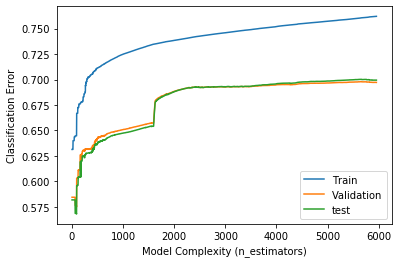

In [144]:
results = model.evals_result()
train_error = results['validation_0']['auc']
val_error = results['validation_1']['auc']
test_error = results['validation_2']['auc']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.plot(epoch, test_error, label='test')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
#plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

In [146]:
y_pred = model.predict(X_test_imputed)
print('Gradient Boosting AUC', roc_auc_score(y_test, y_pred))

Gradient Boosting AUC 0.565014183090969


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [152]:
X_val

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location
38835,1566865,"HOLLYWOOD FOOD MARKET, INC.","HOLLYWOOD FOOD MARKET, INC.",1964668.0,Restaurant,Risk 1 (High),606 E 79TH ST,CHICAGO,IL,60619.0,2015-08-28T00:00:00,Canvass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.751315,-87.609774,"{'longitude': '-87.6097738741829', 'latitude':..."
43507,2045264,PANCHITOS FIT,PANCHITOS FIT,2517697.0,Restaurant,Risk 2 (Medium),3758 W FULLERTON AVE,CHICAGO,IL,60647.0,2017-06-30T00:00:00,License,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.924653,-87.721823,"{'longitude': '-87.72182329917537', 'latitude'..."
37845,1982668,TABLE FIFTY-TWO,BLUE DOOR KITCHEN & GARDEN,1869952.0,Restaurant,Risk 1 (High),52 W ELM ST,CHICAGO,IL,60610.0,2017-02-03T00:00:00,Canvass,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...,41.903256,-87.630503,"{'longitude': '-87.63050298655887', 'latitude'..."
145,277107,BEIJING GARDEN,NaN,2037798.0,Restaurant,Risk 1 (High),1023 W wilson AVE,CHICAGO,IL,60640.0,2010-07-06T00:00:00,License Re-Inspection,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.965311,-87.655781,"{'longitude': '-87.65578121780803', 'latitude'..."
14878,1424255,AIM FOOD MART,A.I.M. FOOD MART,2284298.0,Grocery Store,Risk 3 (Low),1652 W HOWARD ST,CHICAGO,IL,60626.0,2014-05-09T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,42.019494,-87.672884,"{'longitude': '-87.67288403726388', 'latitude'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38001,1441764,MARCELA'S RESTAURANT,CAFETERIA MARCELAS,1874709.0,Restaurant,Risk 1 (High),3503 W FULLERTON AVE,CHICAGO,IL,60647.0,2015-03-11T00:00:00,Canvass Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.924533,-87.713868,"{'longitude': '-87.71386844484053', 'latitude'..."
32682,2102429,EASTERN BREADSTONE BAKERY,EASTERN BREADSTONE BAKERY,1920816.0,Bakery,Risk 2 (Medium),2818 W DEVON AVE,CHICAGO,IL,60659.0,2017-10-24T00:00:00,Canvass Re-Inspection,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.997656,-87.700466,"{'longitude': '-87.70046566561139', 'latitude'..."
49187,1966655,MAKI MASTERS,MAKI MASTERS,2493168.0,Restaurant,Risk 1 (High),604 W BELMONT AVE,CHICAGO,IL,60657.0,2016-10-18T00:00:00,License,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.940149,-87.644663,"{'longitude': '-87.6446627167078', 'latitude':..."
48873,1300709,De Mucho Gusto Taqueria,De Mucho Gusto Taqueria,1991902.0,Restaurant,Risk 1 (High),5606 W Irving Park RD,CHICAGO,IL,60634.0,2012-11-30T00:00:00,Short Form Complaint,NaN,41.953287,-87.767300,"{'longitude': '-87.76730016597165', 'latitude'..."


In [151]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='roc_auc', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_test_imputed, y_test)

feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.1099 ± 0.0047,Inspection Type
0.0520 ± 0.0055,Violations
0.0156 ± 0.0012,License #
0.0090 ± 0.0019,Inspection ID
0.0062 ± 0.0011,Facility Type
0.0061 ± 0.0018,Longitude
0.0058 ± 0.0013,Zip
0.0058 ± 0.0009,Latitude
0.0022 ± 0.0014,Location
0.0006 ± 0.0006,Inspection Date


In [130]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt
from pdpbox import pdp
plt.rcParams['figure.dpi'] = 72

feature = 'Violations'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_imputed, 
    model_features=X_test_imputed.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Violations', 'Inspection Type']

interaction = pdp_interact(
    model=model, 
    dataset=X_test_imputed, 
    model_features=X_test_imputed.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [ ]:
df = pd.DataFrame({
    'id': X_id_test, 
    'pred_proba': y_pred_proba, 
    'status_group': y_test
})

df = df.merge(
     history[['id', 'issue_d', 'sub_grade', 'percent_paid', 'term', 'int_rate']], 
     how='left'
)